<a href="https://colab.research.google.com/github/richardcmg7/sistemascognitivos/blob/main/Actividad_1_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNIR - SISTEMAS COGNITIVOS


> ### RICHARD CAMILO SAAVEDRA CONEO
> #### Actividad 1 Parte 2 - Entrenamiento de Redes Neuronales

# Segunda parte: Aspectos prácticos de las redes neuronales

En esta segunda parte, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en el Tema 4.

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

## 0. Importamos librerias y datos

In [29]:
# Puedes añadir todos los imports adicionales que necesites aquí
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
import time
import matplotlib
import matplotlib.pyplot as plt

### Obtención de los datos y pre-processing

In [30]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

**Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación**

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

*model = Sequential()*

*model.add(lo que sea)  # Definición del modelo*

*model.fit()*

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

### Funciones para graficar

In [31]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# Nota: podéis cambiar los números aquí presentes y ejecutar esta línea si queréis cambiar el tamaño
# de las gráficas
# matplotlib.rcParams['figure.figsize'] = [8, 8]


## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1 *(1.25 puntos)***: Partiendo de una red sencilla como la desarrollada en el Trabajo 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.

*Pista: Usando redes más grandes se hace más sencillo apreciar las diferencias. Es mejor utilizar al menos 3 o 4 capas densas.*

En la libreria KERAS encontramos las siguientes unidades de activación[1]:
<ul>
    <li>relu </li>
    <li>sigmoid </li>
    <li>softmax </li>
    <li>softplus </li>
    <li>softsign </li>
    <li>tanh </li>
    <li>selu </li>
    <li>elu </li>
    <li>exponential </li>
</ul>
Vamos a configurar 3 modelos con capas densas ocultas con las siguientes unidades de activación:

1. [Sigmoid](#sigmoid)
2. [Relu](#relu)
3. [Tanh](#tanh)



### Procesamiento del Dataset

Separamos nuestros datos en datos de entrenamiento X_train y_train y datos de validacion X_valid y y_valid

In [32]:
## Tu código y comentarios de texto aquí
## Puedes incluir tantas celdas como quieras
## No olvides utilizar celdas de Markdown para texto
X_valid, X_train = x_train[:5000], x_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [33]:
print(f"El set de datos X_train es {X_train.shape}")
print(f"El set de datos y_train es {y_train.shape}")
print(f"El set de datos X_valid es {X_valid.shape}")
print(f"El set de datos y_valid es {y_valid.shape}")
print(f"el set de datos de y contiene los siguientes valores unicos {set(y_train)}")
print(" Los cuales corresponden a la categoria de una imagen")

El set de datos X_train es (55000, 28, 28)
El set de datos y_train es (55000,)
El set de datos X_valid es (5000, 28, 28)
El set de datos y_valid es (5000,)
el set de datos de y contiene los siguientes valores unicos {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
 Los cuales corresponden a la categoria de una imagen


### <a name="sigmoid">Capas densas con Sigmoide<a>

In [ ]:
model= keras.models.Sequential()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(128, activation="sigmoid"))
model.add(keras.layers.Dense(64, activation="sigmoid"))
model.add(keras.layers.Dense(64, activation="sigmoid"))
model.add(keras.layers.Dense(32, activation="sigmoid"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 115,306
Trainable params: 115,306
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])

In [ ]:
history1 = model.fit(X_train,y_train,
                    batch_size=64,
                    epochs=20, 
                    validation_data=(X_valid, y_valid))

Epoch 1/20
860/860 [==============================] - 3s 3ms/step - loss: 2.3115 - accuracy: 0.1031 - val_loss: 2.3012 - val_accuracy: 0.1126
Epoch 2/20
860/860 [==============================] - 3s 3ms/step - loss: 2.3014 - accuracy: 0.1077 - val_loss: 2.3010 - val_accuracy: 0.1012
Epoch 3/20
860/860 [==============================] - 3s 3ms/step - loss: 2.3008 - accuracy: 0.1099 - val_loss: 2.3008 - val_accuracy: 0.1642
Epoch 4/20
860/860 [==============================] - 3s 3ms/step - loss: 2.3001 - accuracy: 0.1159 - val_loss: 2.2996 - val_accuracy: 0.1002
Epoch 5/20
860/860 [==============================] - 3s 3ms/step - loss: 2.2992 - accuracy: 0.1182 - val_loss: 2.2986 - val_accuracy: 0.1844
Epoch 6/20
860/860 [==============================] - 3s 3ms/step - loss: 2.2984 - accuracy: 0.1402 - val_loss: 2.2985 - val_accuracy: 0.0914
Epoch 7/20
860/860 [==============================] - 3s 3ms/step - loss: 2.2972 - accuracy: 0.1387 - val_loss: 2.2963 - val_accuracy: 0.0986
Epoch 

### <a name="relu" >Capas Densas con Relu</a>

In [ ]:
model2= keras.models.Sequential()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model2.add(keras.layers.Flatten(input_shape=[28,28]))
model2.add(keras.layers.Dense(128, activation="relu"))
model2.add(keras.layers.Dense(64, activation="relu"))
model2.add(keras.layers.Dense(64, activation="relu"))
model2.add(keras.layers.Dense(32, activation="relu"))
model2.add(keras.layers.Dense(10, activation="softmax"))
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_39 (Dense)             (None, 10)                330       
Total params: 115,306
Trainable params: 115,306
Non-trainable params: 0
________________________________________________

In [ ]:
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer= "sgd",
              metrics =["accuracy"])

In [ ]:
history2 = model2.fit(X_train,y_train,
                    batch_size=64,
                    epochs=20, 
                    validation_data=(X_valid, y_valid))

Epoch 1/20
860/860 [==============================] - 3s 3ms/step - loss: 1.0488 - accuracy: 0.6612 - val_loss: 0.6413 - val_accuracy: 0.7812
Epoch 2/20
860/860 [==============================] - 3s 3ms/step - loss: 0.5815 - accuracy: 0.7984 - val_loss: 0.5466 - val_accuracy: 0.8116
Epoch 3/20
860/860 [==============================] - 3s 3ms/step - loss: 0.5087 - accuracy: 0.8218 - val_loss: 0.5213 - val_accuracy: 0.8102
Epoch 4/20
860/860 [==============================] - 3s 3ms/step - loss: 0.4688 - accuracy: 0.8358 - val_loss: 0.5086 - val_accuracy: 0.8130
Epoch 5/20
860/860 [==============================] - 3s 3ms/step - loss: 0.4411 - accuracy: 0.8435 - val_loss: 0.4483 - val_accuracy: 0.8442
Epoch 6/20
860/860 [==============================] - 3s 3ms/step - loss: 0.4209 - accuracy: 0.8510 - val_loss: 0.4414 - val_accuracy: 0.8478
Epoch 7/20
860/860 [==============================] - 3s 3ms/step - loss: 0.4037 - accuracy: 0.8562 - val_loss: 0.4424 - val_accuracy: 0.8384
Epoch 

### Comparación: Modelo 1 Función de activación Sigmoide Vs Modelo 2 Función de activación Relu

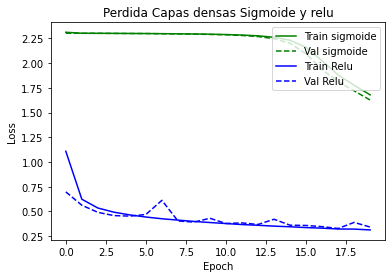

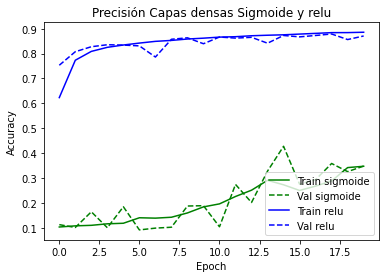

In [ ]:
plot_compare_losses(history1,history2, name1="sigmoide", name2="Relu", title="Perdida Capas densas Sigmoide y relu")
plot_compare_accs(history1,history2,name1= "sigmoide",name2="relu",title="Precisión Capas densas Sigmoide y relu")

* Sigmoide presenta una precisión baja con la configuración dada.
* La función sigmoide puede hacer que la red neuronal se atasque en el momento del entrenamiento.
* Relu converge rapidamente a una precisión superior a 0.8


### <a name="tanh">Capas Densas Función Tanh<a>

In [ ]:
model3= keras.models.Sequential()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model3.add(keras.layers.Flatten(input_shape=[28,28]))
model3.add(keras.layers.Dense(128, activation="tanh"))
model3.add(keras.layers.Dense(64, activation="tanh"))
model3.add(keras.layers.Dense(64, activation="tanh"))
model3.add(keras.layers.Dense(32, activation="tanh"))
model3.add(keras.layers.Dense(10, activation="softmax"))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                330       
Total params: 115,306
Trainable params: 115,306
Non-trainable params: 0
________________________________________________

In [ ]:
model3.compile(loss="sparse_categorical_crossentropy",
                optimizer= "sgd",
                metrics =["accuracy"])
history3 = model3.fit(X_train,y_train,
batch_size=64,
epochs=20,
validation_data=(X_valid, y_valid))

Epoch 1/20
860/860 [==============================] - 2s 3ms/step - loss: 0.8954 - accuracy: 0.7306 - val_loss: 0.5882 - val_accuracy: 0.8120
Epoch 2/20
860/860 [==============================] - 2s 2ms/step - loss: 0.5400 - accuracy: 0.8179 - val_loss: 0.4828 - val_accuracy: 0.8378
Epoch 3/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4754 - accuracy: 0.8346 - val_loss: 0.4472 - val_accuracy: 0.8454
Epoch 4/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4421 - accuracy: 0.8440 - val_loss: 0.4251 - val_accuracy: 0.8552
Epoch 5/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4205 - accuracy: 0.8507 - val_loss: 0.4379 - val_accuracy: 0.8446
Epoch 6/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4043 - accuracy: 0.8563 - val_loss: 0.4032 - val_accuracy: 0.8554
Epoch 7/20
860/860 [==============================] - 2s 3ms/step - loss: 0.3919 - accuracy: 0.8609 - val_loss: 0.3991 - val_accuracy: 0.8560
Epoch 

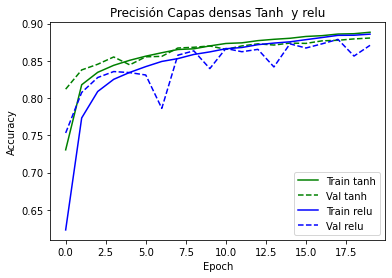

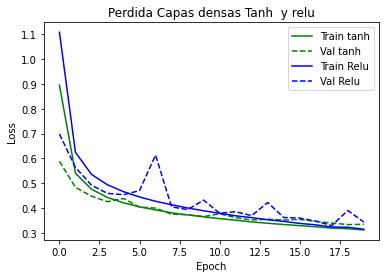

In [ ]:
plot_compare_accs(history3,history2,name1= "tanh",name2="relu",title="Precisión Capas densas Tanh  y relu")
plot_compare_losses(history3,history2, name1="tanh", name2="Relu", title="Perdida Capas densas Tanh  y relu")

### Comparación: Función de Activación Tanh Vs Función de Activación Relu

* El entrenamiento con la función de activacion tanh presenta para este caso un mejor resultado que la Relu obteniendo una precisión un poco mejor.
* El valor de perdida es menor en las primeras epocas del entrenamiento con la función de Activación Tanh.
* La convergencia a una precision del 0.8 es mas rapida con la función Tanh
* Al final los dos modelos obtuvieron resultados muy parecidos.


## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2 *(1.25 puntos)***: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)

### 2.1 Inicialización con ceros [2]

In [ ]:
model4= keras.models.Sequential()
initializer = tf.keras.initializers.Zeros()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model4.add(keras.layers.Flatten(input_shape=[28,28]))
model4.add(keras.layers.Dense(128, activation="relu",kernel_initializer=initializer)) #kernel_initializer='zeros'
model4.add(keras.layers.Dense(64, activation="relu", kernel_initializer=initializer))
model4.add(keras.layers.Dense(32, activation="relu", kernel_initializer=initializer))
model4.add(keras.layers.Dense(10, activation="softmax"))
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.compile(loss="sparse_categorical_crossentropy",
                optimizer= "sgd",
                metrics =["accuracy"])
history4 = model4.fit(X_train,y_train,
                        batch_size=64,
                        epochs=20,
                        validation_data=(X_valid, y_valid))

Epoch 1/20
860/860 [==============================] - 3s 3ms/step - loss: 2.3026 - accuracy: 0.0991 - val_loss: 2.3028 - val_accuracy: 0.0914
Epoch 2/20
860/860 [==============================] - 2s 3ms/step - loss: 2.3026 - accuracy: 0.0990 - val_loss: 2.3027 - val_accuracy: 0.0914
Epoch 3/20
860/860 [==============================] - 2s 3ms/step - loss: 2.3026 - accuracy: 0.0989 - val_loss: 2.3027 - val_accuracy: 0.0914
Epoch 4/20
860/860 [==============================] - 2s 3ms/step - loss: 2.3026 - accuracy: 0.0997 - val_loss: 2.3027 - val_accuracy: 0.0914
Epoch 5/20
860/860 [==============================] - 2s 3ms/step - loss: 2.3026 - accuracy: 0.0990 - val_loss: 2.3028 - val_accuracy: 0.0914
Epoch 6/20
860/860 [==============================] - 2s 3ms/step - loss: 2.3026 - accuracy: 0.1002 - val_loss: 2.3028 - val_accuracy: 0.0914
Epoch 7/20
860/860 [==============================] - 2s 3ms/step - loss: 2.3026 - accuracy: 0.0979 - val_loss: 2.3029 - val_accuracy: 0.0914
Epoch 

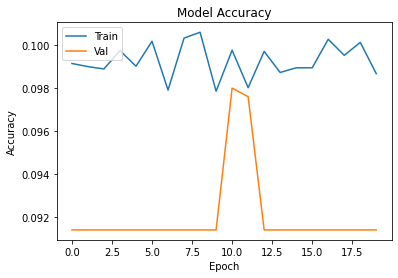

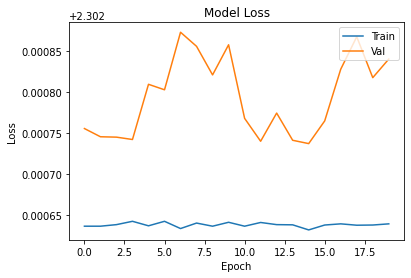

In [ ]:
plot_acc(history4, title="Model Accuracy")
plot_loss(history4, title="Model Loss")

### 2.2 Inicialización con con una variable aleatoria normal.

In [ ]:
model5= keras.models.Sequential()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model5.add(keras.layers.Flatten(input_shape=[28,28]))
model5.add(keras.layers.Dense(128, activation="relu",kernel_initializer='random_normal'))
model5.add(keras.layers.Dense(64, activation="relu", kernel_initializer='random_normal'))
model5.add(keras.layers.Dense(32, activation="relu", kernel_initializer='random_normal'))
model5.add(keras.layers.Dense(10, activation="softmax"))
model5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model5.compile(loss="sparse_categorical_crossentropy",
                optimizer= "sgd",
                metrics =["accuracy"])
history5 = model5.fit(X_train,y_train,
                        batch_size=64,
                        epochs=20,
                        validation_data=(X_valid, y_valid))

Epoch 1/20
860/860 [==============================] - 2s 3ms/step - loss: 1.5346 - accuracy: 0.4775 - val_loss: 0.8815 - val_accuracy: 0.6584
Epoch 2/20
860/860 [==============================] - 2s 3ms/step - loss: 0.7682 - accuracy: 0.7177 - val_loss: 0.6784 - val_accuracy: 0.7652
Epoch 3/20
860/860 [==============================] - 2s 3ms/step - loss: 0.6338 - accuracy: 0.7744 - val_loss: 0.6735 - val_accuracy: 0.7466
Epoch 4/20
860/860 [==============================] - 2s 2ms/step - loss: 0.5663 - accuracy: 0.8030 - val_loss: 0.5406 - val_accuracy: 0.8128
Epoch 5/20
860/860 [==============================] - 2s 3ms/step - loss: 0.5260 - accuracy: 0.8158 - val_loss: 0.4934 - val_accuracy: 0.8336
Epoch 6/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4972 - accuracy: 0.8265 - val_loss: 0.4986 - val_accuracy: 0.8206
Epoch 7/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4757 - accuracy: 0.8336 - val_loss: 0.4560 - val_accuracy: 0.8450
Epoch 

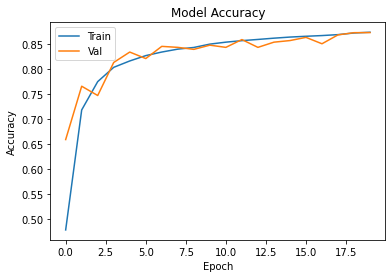

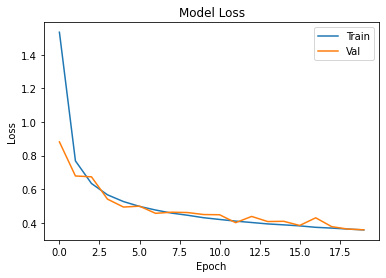

In [ ]:
plot_acc(history5, title="Model Accuracy")
plot_loss(history5, title="Model Loss")

### 2.3 Inicialización valores por defecto keras (estrategia glorot uniform)

In [ ]:
model6= keras.models.Sequential()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model6.add(keras.layers.Flatten(input_shape=[28,28]))
model6.add(keras.layers.Dense(128, activation="relu",kernel_initializer='glorot_uniform'))
model6.add(keras.layers.Dense(64, activation="relu", kernel_initializer='glorot_uniform'))
model6.add(keras.layers.Dense(32, activation="relu", kernel_initializer='glorot_uniform'))
model6.add(keras.layers.Dense(10, activation="softmax"))
model6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model6.compile(loss="sparse_categorical_crossentropy",
                optimizer= "sgd",
                metrics =["accuracy"])
history6 = model6.fit(X_train,y_train,
                        batch_size=64,
                        epochs=20,
                        validation_data=(X_valid, y_valid))

Epoch 1/20
860/860 [==============================] - 2s 3ms/step - loss: 0.9884 - accuracy: 0.6812 - val_loss: 0.6092 - val_accuracy: 0.7946
Epoch 2/20
860/860 [==============================] - 2s 3ms/step - loss: 0.5634 - accuracy: 0.8063 - val_loss: 0.5136 - val_accuracy: 0.8270
Epoch 3/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4948 - accuracy: 0.8271 - val_loss: 0.5112 - val_accuracy: 0.8286
Epoch 4/20
860/860 [==============================] - 2s 2ms/step - loss: 0.4608 - accuracy: 0.8381 - val_loss: 0.4385 - val_accuracy: 0.8488
Epoch 5/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4368 - accuracy: 0.8464 - val_loss: 0.4209 - val_accuracy: 0.8554
Epoch 6/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4206 - accuracy: 0.8511 - val_loss: 0.3998 - val_accuracy: 0.8598
Epoch 7/20
860/860 [==============================] - 2s 3ms/step - loss: 0.4052 - accuracy: 0.8569 - val_loss: 0.5088 - val_accuracy: 0.8208
Epoch 

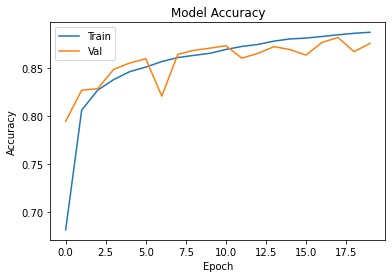

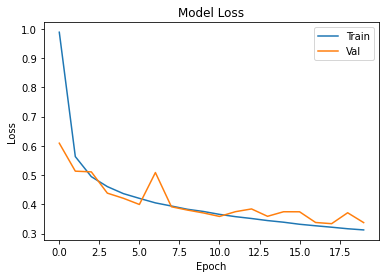

In [ ]:
plot_acc(history6, title="Model Accuracy")
plot_loss(history6, title="Model Loss")

### 2.4 Conclusiones resultados obtenidos

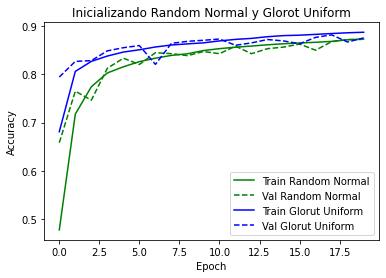

In [ ]:
plot_compare_accs(history5, history6, name1="Random Normal",name2="Glorut Uniform", title="Inicializando Random Normal y Glorot Uniform")

* Iniciando los pesos en 0 de las neuronas en las capas densas muestra que no converge ni la red neuronal logra entrenarse.
* Para el inicio de los pesos de manera aleatoria se logra un resultado de precision y validación para las epocas dadas de 87%. Se observa que tanto entrenamiento como validación muestran resultados casi similares
* Kernel initializer glorot_uniform logra una precision del 88,7% pero para los datos de validación se mantiene en 0.87. 

## 3. Optimizadores

**Ejercicio 3 *(1.25 puntos)***: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

El optimizador es uno de los dos paramtros que se deben brindar para compilar un modelo, por defecto utiliza el optimizador Adam. Para KERAS podemos encontrar los siquientes Optimizadores:<br>

|   |Optimizador | 
|---|:----------:|
| 0 |  SGD       |  
| 1 |  RMSprop   |   
| 2 |  Adam      |
| 3 |  Adadelta       |  
| 4 |  Adagrad   |   
| 5 |  Adamax      |
| 6 |  Nadam   |   
| 7 |  Ftrl      |


Se realizaron los ajustes utilizando los siguientes optimizadores:
1. [Optimizador SGD](#sgd)
2. [Optimizador Adam.](#adam)
3. [Optimizador RMSprop.](#rmsprop)

### <a name="sgd">3.1 Optimizador SGD</a>

In [ ]:
model7= keras.models.Sequential()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model7.add(keras.layers.Flatten(input_shape=[28,28]))
model7.add(keras.layers.Dense(128, activation="relu",kernel_initializer='glorot_uniform'))
model7.add(keras.layers.Dense(64, activation="relu", kernel_initializer='glorot_uniform'))
model7.add(keras.layers.Dense(32, activation="relu", kernel_initializer='glorot_uniform'))
model7.add(keras.layers.Dense(10, activation="softmax"))
model7.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_31 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time
start_time = time.time()

opt = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
model7.compile(loss="sparse_categorical_crossentropy",
                optimizer= opt,
                metrics =["accuracy"])
history7 = model7.fit(X_train,y_train,
                        batch_size=64,
                        epochs=20,
                        validation_data=(X_valid, y_valid))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
860/860 [==============================] - 2s 3ms/step - loss: 0.3146 - accuracy: 0.8876 - val_loss: 0.3421 - val_accuracy: 0.8810
Epoch 2/20
860/860 [==============================] - 2s 3ms/step - loss: 0.3086 - accuracy: 0.8890 - val_loss: 0.3539 - val_accuracy: 0.8728
Epoch 3/20
860/860 [==============================] - 2s 3ms/step - loss: 0.3059 - accuracy: 0.8895 - val_loss: 0.4534 - val_accuracy: 0.8388
Epoch 4/20
860/860 [==============================] - 2s 3ms/step - loss: 0.3017 - accuracy: 0.8915 - val_loss: 0.3621 - val_accuracy: 0.8700
Epoch 5/20
860/860 [==============================] - 2s 3ms/step - loss: 0.2974 - accuracy: 0.8921 - val_loss: 0.3378 - val_accuracy: 0.8778
Epoch 6/20
860/860 [==============================] - 2s 3ms/step - loss: 0.2925 - accuracy: 0.8944 - val_loss: 0.3346 - val_accuracy: 0.8808
Epoch 7/20
860/860 [==============================] - 2s 3ms/step - loss: 0.2895 - accuracy: 0.8959 - val_loss: 0.3403 - val_accuracy: 0.8806
Epoch 

#### SGD Learning rate diferente

In [ ]:
model8= keras.models.Sequential()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model8.add(keras.layers.Flatten(input_shape=[28,28]))
model8.add(keras.layers.Dense(128, activation="relu",kernel_initializer='glorot_uniform'))
model8.add(keras.layers.Dense(64, activation="relu", kernel_initializer='glorot_uniform'))
model8.add(keras.layers.Dense(32, activation="relu", kernel_initializer='glorot_uniform'))
model8.add(keras.layers.Dense(10, activation="softmax"))
model8.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time
start_time = time.time()

opt = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
model8.compile(loss="sparse_categorical_crossentropy",
                optimizer= opt,
                metrics =["accuracy"])
history8 = model8.fit(X_train,y_train,
                        batch_size=64,
                        epochs=20,
                        validation_data=(X_valid, y_valid))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
860/860 [==============================] - 2s 3ms/step - loss: 2.0675 - accuracy: 0.3300 - val_loss: 1.8366 - val_accuracy: 0.4690
Epoch 2/20
860/860 [==============================] - 2s 3ms/step - loss: 1.5797 - accuracy: 0.5499 - val_loss: 1.3262 - val_accuracy: 0.6300
Epoch 3/20
860/860 [==============================] - 2s 3ms/step - loss: 1.1381 - accuracy: 0.6671 - val_loss: 0.9757 - val_accuracy: 0.6928
Epoch 4/20
860/860 [==============================] - 2s 3ms/step - loss: 0.9091 - accuracy: 0.7097 - val_loss: 0.8320 - val_accuracy: 0.7294
Epoch 5/20
860/860 [==============================] - 2s 3ms/step - loss: 0.8064 - accuracy: 0.7356 - val_loss: 0.7573 - val_accuracy: 0.7488
Epoch 6/20
860/860 [==============================] - 2s 3ms/step - loss: 0.7460 - accuracy: 0.7548 - val_loss: 0.7078 - val_accuracy: 0.7628
Epoch 7/20
860/860 [==============================] - 2s 3ms/step - loss: 0.7034 - accuracy: 0.7696 - val_loss: 0.6729 - val_accuracy: 0.7756
Epoch 

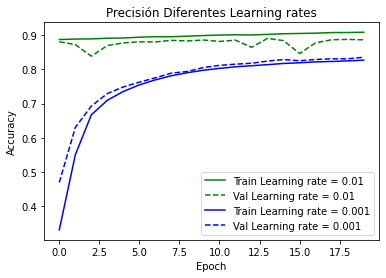

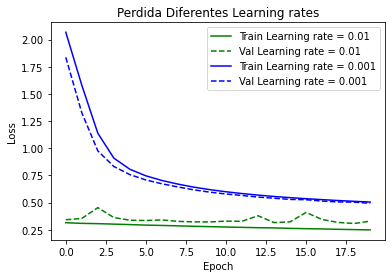

In [ ]:
plot_compare_accs(history7, history8, name1="Learning rate = 0.01",name2="Learning rate = 0.001", title="Precisión Diferentes Learning rates")
plot_compare_losses(history7, history8, name1="Learning rate = 0.01",name2="Learning rate = 0.001", title="Perdida Diferentes Learning rates")

### <a name="adam">3.2 Optimizador Adam</a>

In [ ]:
model9= keras.models.Sequential()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model9.add(keras.layers.Flatten(input_shape=[28,28]))
model9.add(keras.layers.Dense(128, activation="relu",kernel_initializer='glorot_uniform'))
model9.add(keras.layers.Dense(64, activation="relu", kernel_initializer='glorot_uniform'))
model9.add(keras.layers.Dense(32, activation="relu", kernel_initializer='glorot_uniform'))
model9.add(keras.layers.Dense(10, activation="softmax"))
model9.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_39 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start_time = time.time()
model9.compile(loss="sparse_categorical_crossentropy",
                optimizer= 'adam',
                metrics =["accuracy"])
history9 = model9.fit(X_train,y_train,
                        batch_size=64,
                        epochs=20,
                        validation_data=(X_valid, y_valid))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
860/860 [==============================] - 3s 4ms/step - loss: 0.5312 - accuracy: 0.8128 - val_loss: 0.4055 - val_accuracy: 0.8542
Epoch 2/20
860/860 [==============================] - 3s 3ms/step - loss: 0.3885 - accuracy: 0.8591 - val_loss: 0.3598 - val_accuracy: 0.8684
Epoch 3/20
860/860 [==============================] - 3s 4ms/step - loss: 0.3462 - accuracy: 0.8738 - val_loss: 0.3544 - val_accuracy: 0.8718
Epoch 4/20
860/860 [==============================] - 3s 3ms/step - loss: 0.3254 - accuracy: 0.8808 - val_loss: 0.3593 - val_accuracy: 0.8744
Epoch 5/20
860/860 [==============================] - 3s 3ms/step - loss: 0.3067 - accuracy: 0.8874 - val_loss: 0.3148 - val_accuracy: 0.8848
Epoch 6/20
860/860 [==============================] - 3s 3ms/step - loss: 0.2894 - accuracy: 0.8928 - val_loss: 0.3156 - val_accuracy: 0.8868
Epoch 7/20
860/860 [==============================] - 3s 3ms/step - loss: 0.2759 - accuracy: 0.8973 - val_loss: 0.3212 - val_accuracy: 0.8904
Epoch 

### <a name="rmsprop">3.3 Optimizador RMSprop</a>

In [ ]:
model10= keras.models.Sequential()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model10.add(keras.layers.Flatten(input_shape=[28,28]))
model10.add(keras.layers.Dense(128, activation="relu",kernel_initializer='glorot_uniform'))
model10.add(keras.layers.Dense(64, activation="relu", kernel_initializer='glorot_uniform'))
model10.add(keras.layers.Dense(32, activation="relu", kernel_initializer='glorot_uniform'))
model10.add(keras.layers.Dense(10, activation="softmax"))
model10.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_42 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_43 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start_time = time.time()
model10.compile(loss="sparse_categorical_crossentropy",
                optimizer= 'rmsprop',
                metrics =["accuracy"])
history10 = model10.fit(X_train,y_train,
                        batch_size=64,
                        epochs=20,
                        validation_data=(X_valid, y_valid))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
860/860 [==============================] - 3s 4ms/step - loss: 0.5576 - accuracy: 0.8001 - val_loss: 0.5313 - val_accuracy: 0.8040
Epoch 2/20
860/860 [==============================] - 3s 4ms/step - loss: 0.3920 - accuracy: 0.8566 - val_loss: 0.4541 - val_accuracy: 0.8444
Epoch 3/20
860/860 [==============================] - 3s 4ms/step - loss: 0.3524 - accuracy: 0.8712 - val_loss: 0.3783 - val_accuracy: 0.8606
Epoch 4/20
860/860 [==============================] - 3s 4ms/step - loss: 0.3290 - accuracy: 0.8787 - val_loss: 0.4192 - val_accuracy: 0.8474
Epoch 5/20
860/860 [==============================] - 3s 4ms/step - loss: 0.3137 - accuracy: 0.8839 - val_loss: 0.3314 - val_accuracy: 0.8830
Epoch 6/20
860/860 [==============================] - 3s 4ms/step - loss: 0.2962 - accuracy: 0.8911 - val_loss: 0.3525 - val_accuracy: 0.8798
Epoch 7/20
860/860 [==============================] - 4s 4ms/step - loss: 0.2861 - accuracy: 0.8947 - val_loss: 0.3848 - val_accuracy: 0.8676
Epoch 

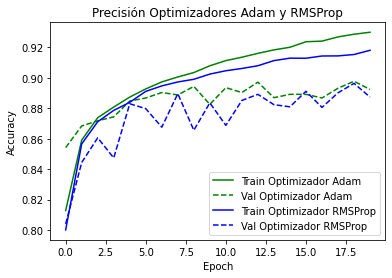

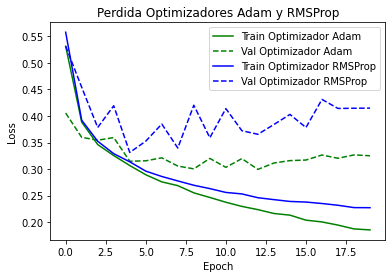

In [ ]:
plot_compare_accs(history9, history10, name1="Optimizador Adam",name2="Optimizador RMSProp", title="Precisión Optimizadores Adam y RMSProp")
plot_compare_losses(history9, history10, name1="Optimizador Adam",name2="Optimizador RMSProp", title="Perdida Optimizadores Adam y RMSProp")

### 2.4 Conclusiones resultados obtenidos



* Configurando los hiper-parametros para el optimizador SGD con valores de 0.01 se obtuvo una precisión superior al 90% en entrenamiento y 88.6% con datos de validación.
* Con un valor de Larning rate mas bajo 0.001 disminuyo el nivel de presición y convergencia obteniendo valores cercanos al 83%.
* Los tiempos para la ejecucion de la red con el optimizador SGD y distintos learning rate se encontro cercano a los 46s.
* Para los optimizadores Adam y RMSprop se supero niveles de precisión en entrenamiento del 91% pero se observa que para los datos de validación se situaron por debajo de 89%. La red con estos 2 modelos se sobre entrenaron.
* El tiempo de entrenamiento de la red para Adam fue superior a SGD 52" y para RMSProp 65" siendo mas lentos que el entrenamiento realizado que con SGD. 
* El mejor optimizador para la fase de entrenamiento fue "Adam" superior a 0,93

## 4. Regularización y red final *(1.25 puntos)*

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

### Implementación Red Final

In [ ]:
model12= keras.models.Sequential()
initializer = tf.keras.initializers.Zeros()
# El tamaño de entrada  corresponde al tamaño de la imagen 28x28
model12.add(keras.layers.Flatten(input_shape=[28,28]))
#model12.add(tf.keras.layers.BatchNormalization())
model12.add(tf.keras.layers.Dropout(0.20))
model12.add(keras.layers.Dense(128, activation="relu",kernel_initializer='glorot_uniform'))
#model12.add(tf.keras.layers.Dropout(0.20))
model12.add(keras.layers.Dense(64, activation="relu", kernel_initializer='glorot_uniform'))
model12.add(keras.layers.Dense(64, activation="relu", kernel_initializer='glorot_uniform'))
#model12.add(tf.keras.layers.Dropout(0.20))
model12.add(keras.layers.Dense(10, activation="softmax"))
start_time = time.time()
model12.compile(loss="sparse_categorical_crossentropy",
                optimizer= 'adam',
                metrics =["accuracy"])
history12 = model12.fit(X_train,y_train,
                        batch_size=32,
                        epochs=20,
                        validation_data=(X_valid, y_valid))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5468 - accuracy: 0.8019 - val_loss: 0.3918 - val_accuracy: 0.8562
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4138 - accuracy: 0.8465 - val_loss: 0.3457 - val_accuracy: 0.8738
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3796 - accuracy: 0.8570 - val_loss: 0.3501 - val_accuracy: 0.8676
Epoch 4/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3589 - accuracy: 0.8656 - val_loss: 0.3411 - val_accuracy: 0.8748
Epoch 5/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3413 - accuracy: 0.8725 - val_loss: 0.3177 - val_accuracy: 0.8826
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3305 - accuracy: 0.8758 - val_loss: 0.3179 - val_accuracy: 0.8848
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3196 - accuracy: 0.8800 - val_loss: 0.3085 - val_accuracy:

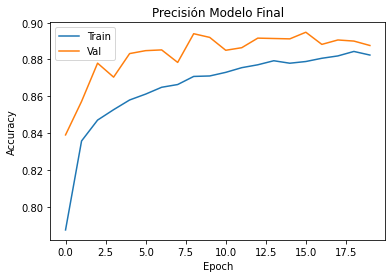

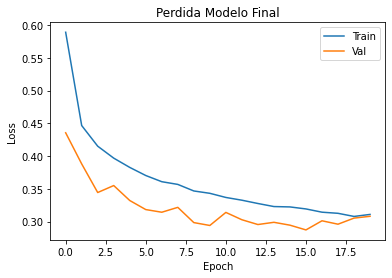

In [ ]:
plot_acc(history12, title="Precisión Modelo Final")
plot_loss(history12, title="Perdida Modelo Final")

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

In [34]:
print("Evaluando el modelo con los datos de Test: ")
test_loss, test_accuracy = model12.evaluate(x_test, y_test, batch_size=64)
print("Perdida datos de Test, Precisión Datos de test:", test_loss)
print("***********************************************************")
print(f"La presición de los datos de test es de: {test_accuracy}")

Evaluando el modelo con los datos de Test: 
157/157 [==============================] - 0s 1ms/step - loss: 0.3268 - accuracy: 0.8825
Perdida datos de Test, Precisión Datos de test: 0.32681190967559814
***********************************************************
La presición de los datos de test es de: 0.8824999928474426


Se logra con datos de Test (No antes visto por la red neuronal) en este ultimo entrenamiento una precisión de  0.882 y valor de perdida de 0.32 el tiempo de entrenamiento para esta red fue de 92 segundos.  Se logra unos resultado muy cercanos a la evaluación realizada con los datos de validación.

### 4.2 Conclusiones Regularización y Red Final

Para la aproximación final, se tuvo encuenta el mejor modelo entrenado anteriormente.<br>
* Se configuro una red inicial con unas capas determinadas.
* Se realizaron pruebas con diferentes inicializadores encontrando la glorot uniform el mejor de ellos.
* Se Configuraron diferentes optimizadores siendo <b>Adam </b> el que mejor resultado presento.
* Se Probaron diferentes técnicas de regularización que pemitieron mejorar el overfitting
* Se selecciono finalmente el modelo que se entrenaba en un tiempo de entrenamiento de la red intermedio y logrando la menor perdida en validación. 

<h3>Consideraciones:</h3>
<h4 align="center">Regularizacion</h4> 
<hr>
<p>Se realiza la implementación de diferentes tecnicas de regularización L1 L2 y Dropout.</p>
<p>La implementación se realizó a través de las diferentes capas ocultas combinando la presencia o ausencia de las mismas.  </p>
<p> Los resultados obtenidos de las diferentes pruebas fueron muy cercanos, el mejor resultado se encontro implementando la Técnica <b>Dropout</b> despues de la capa de entrada. El valor de 0,2 como parametro para Dropout presento mejor resultado que un valor mayor (0.25). </p>
<p> Al ingresar la técnica Dropout el <b>tiempo del entrenamiento</b> aumento, la precisión y perdida mejoraron respecto a los datos de validación. Lo que da a entender que controlo el overfitting que se estaba presentando en el modelo con optimiza Adam sin regularización.</p>
<p> Se implementro Con <b>batchNormalization</b> entre la capa entrada y la primera capa densa. En el entrenamiento supero el 0.95 con datos de entrenamiento pero se mantuvo en 0.89 con datos de validación por lo que entro en overfitting. Presentando un valor de perdida mayor que con otros modelos.</p>
<p> Con Batch Normalization se implementa en medio de otras capas Dropout para buscar controlar el overfitting, se logra llegar en datos de validación el 0,9 pero en datos de test se llega a 0.893. 
El tiempo de este entrenamiento fue de 223 segundos. 
</p>
<h4 align="center">Epocas</h4> 
<hr>
<p> Se aumento la cantidad de epocas permitiendo que se entrenara aun mas la red. En promedio para este modelo final despues de las 23 epocas entraban en sobre entrenamiento.(sin tener encuenta cambios en el optimizador o regularizador)</p>
<h4 align="center">Tiempos de Entrenamiento</h4> 
<hr>
<p>Los diferentes modelos presentaron resultados muy cercanos mejorando algunos puntos porcentuales al aplicar una o mas estrategia o técnicas en medio de las capas. Al aplicar estas técnicas aumentaron los tiempos en que se entrenaba una red. Esto invita a validar o tener en cuenta la importancia de mejorar un modelo Vs el tiempo que este puede demorarse en entrenarse. En el ejercicio realizado tenemos modelos de 0.88(con datos de validacion o test) entrenado en aprox 50" segundos y otro con 0.893 de presición con un tiempo de 260". 

## Referencias

[1] https://keras.io/api/layers/activations/ <br>
[2] https://keras.io/api/layers/initializers/ <br>
[3] https://keras.io/api/layers/regularization_layers/ <br>

___
<p align="center">Fin Segunda Parte de la Actividad 1. Entrenamiento de Redes Neuronales
<br><b>Richard Camilo Saavedra Coneo</b><br><time datetime="2020-10-26">26 de Octubre de 2020</time>
</p>